In [1]:
import numpy as np
import scipy.signal
from matplotlib.pyplot import *
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
from filter_function import *
from spectrogram import *
from wav_preprocessing import *
import matplotlib.image as mpimg
import glob
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, UpSampling2D, Input,Dropout,Conv2DTranspose,Concatenate
from keras.layers import  Conv1D, MaxPooling1D, UpSampling1D,Concatenate, PReLU
from keras import optimizers
from error_measure import *

Using TensorFlow backend.


In [2]:
original_dataset_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\recordings\\"

base_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\super_resolution_re_im"
train_dir = os.path.join(base_dir, 'train\\')

test_dir = os.path.join(base_dir, 'test\\')
train_dir_filtré=os.path.join(base_dir, 'train_dir_filtré\\')
test_dir_filtré=os.path.join(base_dir, 'test_dir_filtré\\')

In [3]:
Xtest,max_test= dir_to_wav_array(test_dir)
Xtrain,max_train= dir_to_wav_array(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [367]:
fce=0.1360#sr=22050
ftype="butter"
ordre=2
b,a = creer_filter(fce,"highpass",ftype,ordre)
filter_path(train_dir,train_dir_filtré,b,a)
filter_path(test_dir,test_dir_filtré,b,a)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\


In [368]:
# Xtrain_fil,max_train_fil=dir_to_wav_array(train_dir_filtré)
Xtest_fil,max_test_fil=dir_to_wav_array(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [27]:
#réseau audio net
input_img = Input(shape=(8000,1,1))

conv1= Conv2D(32, (7, 1), padding='same',strides=1)(input_img)
conv1 = PReLU(shared_axes=[1, 2], name='prelu1')(conv1)
max1= MaxPooling2D((2, 1), padding='same')(conv1)

conv3 = Conv2D(32, (7, 1), padding='same',strides=1)(max1)
conv3 = PReLU(shared_axes=[1, 2], name='prelu3')(conv3)              
encoded = MaxPooling2D((2, 1), padding='same')(conv3)
x = Conv2D(32, (7, 1), padding='same',strides=1)(encoded)
x = PReLU(shared_axes=[1, 2], name='prelu4')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu5')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu6')(x)

x = UpSampling2D((2, 1))(x)
# merge2=Concatenate(axis=-1)([x,conv3])
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu8')(x)
# x=Dropout(0.5)(x)
x = UpSampling2D((2, 1))(x)
# merge1=Concatenate(axis=-1)([x,conv1])
decoded = Conv2D(1, (7, 1), padding='same',strides=1)(x)
decoded = PReLU(shared_axes=[1, 2], name='prelu9')(decoded)
# decoded=Dropout(0.5)(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8000, 1, 1)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8000, 1, 32)       256       
_________________________________________________________________
prelu1 (PReLU)               (None, 8000, 1, 32)       32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4000, 1, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4000, 1, 32)       7200      
_________________________________________________________________
prelu3 (PReLU)               (None, 4000, 1, 32)       32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2000, 1, 32)       0         
__________

In [28]:
# autoencoder.clear_session()

In [29]:
G=1
history=autoencoder.fit(Xtrain_fil*G,Xtrain*G,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil*G, Xtest*G))

Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0624 - val_loss: 0.0568
Epoch 2/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0299 - val_loss: 0.0181
Epoch 3/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0181 - val_loss: 0.0157
Epoch 4/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0162 - val_loss: 0.0143
Epoch 5/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0149 - val_loss: 0.0133
Epoch 6/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0143 - val_loss: 0.0126
Epoch 7/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0135 - val_loss: 0.0131
Epoch 8/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0127 - val_loss: 0.0114
Epoch 9/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 10/40
1800/1800 [===========

In [30]:
# autoencoder.save("audio_network_low_250Hz_80epochs.h5")

In [416]:
autoencoder=load_model("audio_network_3000Hz_80epochs.h5")

In [417]:
decoded = autoencoder.predict(Xtest_fil)

In [418]:
# decoded=wav_postprocessing(decoded)
# Xtest=wav_postprocessing(Xtest)
# Xtest_fil=wav_postprocessing(Xtest_fil)

In [419]:
p=122
sr=8000
#indice to display
xtest=np.reshape(Xtest[p],(8000))
audio_path_record="C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\"
audio_path_record_in=os.path.join(audio_path_record,"0_jackson_0_wav_test.wav")
soundfile.write(audio_path_record_in,xtest,sr)
ipd.Audio(audio_path_record_in)

In [420]:
y=np.reshape(decoded[p],(8000))
bpost,apost=creer_filter(0.005,"highpass","butter",ordre=6)
y_fil=filtrage(bpost,apost,y)
audio_path_record_out=os.path.join(audio_path_record,"0_jackson_0_wav_reconstructed.wav")
soundfile.write(audio_path_record_out,y,sr)
ipd.Audio(audio_path_record_out)

In [421]:
xtest_fil=np.reshape(Xtest_fil[p],(8000))
audio_path_record_in_fil=os.path.join(audio_path_record,"0_jackson_0_filtered.wav")
soundfile.write(audio_path_record_in_fil,xtest_fil,sr)
ipd.Audio(audio_path_record_in_fil)

(1025, 16)
(1025, 16)
(1025, 16)


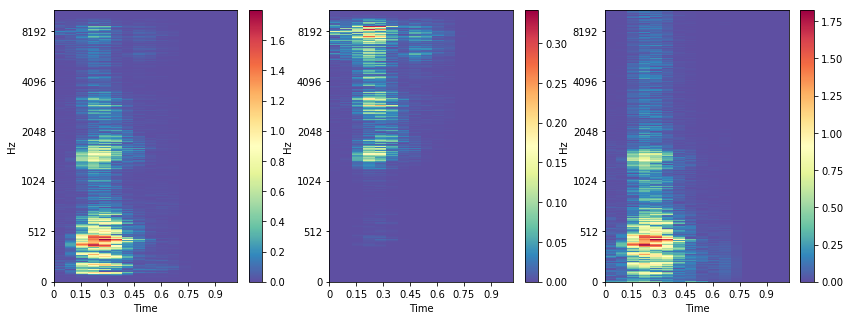

In [422]:
X=librosa.stft(xtest*max_test[p])
Xdec=librosa.stft(y*max_test[p])
Xfil=librosa.stft(xtest_fil*max_test_fil[p])
figure(figsize=(14, 5))
plt.subplot(1,3,1)
Xdb = np.log10(abs(X)+1)
print(Xdb.shape)
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,2)
Xfildb = np.log10(abs(Xfil)+1)
print(Xfildb.shape)
librosa.display.specshow(Xfildb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,3)
Xdecdb = np.log10(abs(Xdec)+1)
print(Xdecdb.shape)
librosa.display.specshow(Xdecdb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()

In [3]:
Xtest_lin,Phase_test=dir_to_log_mag_spec(test_dir)
Xtrain_lin,Phase_train=dir_to_log_mag_spec(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [4]:
Xtrain_fil_lin,Phase_train_fil=dir_to_log_mag_spec(train_dir_filtré)
Xtest_fil_lin,Phase_test_fil=dir_to_log_mag_spec(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_28.wav
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [5]:
input_spec = Input(shape=(1024, 16,1))

conv1= Conv2D(32, (3, 3), activation='relu', padding='same')(input_spec)
max1= MaxPooling2D((2, 1), padding='same')(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(max1)
encoded = MaxPooling2D((2, 1), padding='same')(conv2)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 1))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 1))(x)



decoded_spec = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
autoencoder_spec = Model(input_spec, decoded_spec)
autoencoder_spec.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder_spec.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 16, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 16, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 16, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 16, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 256, 16, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 16, 32)       9248      
_________________________________________________________________
conv

In [6]:
# autoencoder_spec.clear_session()

In [7]:
history=autoencoder_spec.fit(Xtrain_fil_lin,Xtrain_lin,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil_lin, Xtest_lin))

Instructions for updating:
Use tf.cast instead.
Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 30s 17ms/step - loss: 0.0290 - val_loss: 0.0256
Epoch 2/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0264 - val_loss: 0.0247
Epoch 3/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0256 - val_loss: 0.0239
Epoch 4/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0251 - val_loss: 0.0247
Epoch 5/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0257 - val_loss: 0.0236
Epoch 6/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0247 - val_loss: 0.0233
Epoch 7/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0238 - val_loss: 0.0219
Epoch 8/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0222 - val_loss: 0.0206
Epoch 9/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0

In [8]:
# autoencoder_spec.save("spec_lin_network_3000Hz_80epochs.h5")

In [9]:
# autoencoder_spec=load_model("spec_lin_network_low_1500Hz_40epochs.h5")

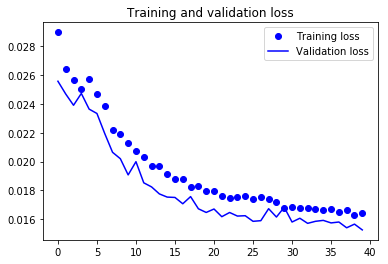

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [429]:
decoded_lin = autoencoder_spec.predict(Xtest_fil_lin)

In [430]:

mix_audio=merge_logspecphase_to_audio(np.reshape(decoded_lin,(decoded_lin.shape[0],decoded_lin.shape[1],decoded_lin.shape[2])),decoded)

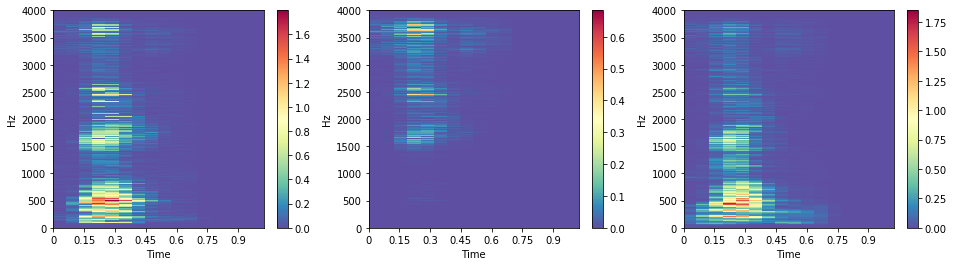

In [431]:
p3=122
Spec_dec=np.reshape(decoded_lin[p3],(decoded_lin.shape[1],decoded_lin.shape[2]))
Spec=np.reshape(Xtest_lin[p3],(Xtest_lin.shape[1],Xtest_lin.shape[2]))
Spec_fil=np.reshape(Xtest_fil_lin[p3],(Xtest_fil_lin.shape[1],Xtest_fil_lin.shape[2]))
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
librosa.display.specshow(Spec, sr=8000, x_axis='time', y_axis='hz',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,3,2)
librosa.display.specshow(Spec_fil, sr=8000, x_axis='time', y_axis='hz',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,3,3)
librosa.display.specshow(Spec_dec, sr=8000, x_axis='time', y_axis='hz',fmax=4000,cmap='Spectral_r')
colorbar()

In [432]:

xtest3=np.reshape(Xtest[p3],(8000))
soundfile.write(audio_path_record_in,xtest3*max_test[p3],sr)
ipd.Audio(audio_path_record_in)

In [433]:
xtest3_fil=np.reshape(Xtest_fil[p3],(8000))
soundfile.write(audio_path_record_in_fil,xtest3_fil*max_test_fil[p3],sr)
ipd.Audio(audio_path_record_in_fil)

In [434]:
y3=np.reshape(decoded[p3],(8000))
audio_path_record_out3=os.path.join(audio_path_record,"3_reconstructed.wav")
soundfile.write(audio_path_record_out3,y3*max_test[p3],sr)
ipd.Audio(audio_path_record_out3)

In [435]:
audio_path_record_audio_mix3=os.path.join(audio_path_record,"3_mix.wav")
soundfile.write(audio_path_record_audio_mix3,mix_audio[p3],sr)
ipd.Audio(audio_path_record_audio_mix3)

In [436]:
Xtest_mel,Phase_test=dir_to_log_mel(test_dir)
Xtest_fil_mel,Phase_test_fil=dir_to_log_mel(test_dir_filtré)
print(mse_melSpectro(Xtest_mel,Xtest_fil_mel))

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\
9.073598754380241e-05


In [437]:
autoencoder_mel=load_model("mel_spec_network_3000Hz_80epochs.h5")
decoded_mel=autoencoder_mel.predict(Xtest_fil_mel)

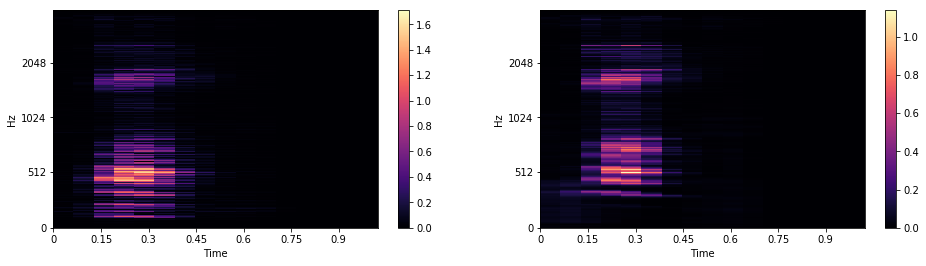

In [438]:


Spec_dec_mel=np.reshape(decoded_mel[p3],(decoded_mel.shape[1],decoded_mel.shape[2]))
Spec_mel=np.reshape(Xtest_mel[p3],(Xtest_mel.shape[1],Xtest_mel.shape[2]))

plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
librosa.display.specshow(Spec_mel, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()
plt.subplot(1,2,2)
librosa.display.specshow(Spec_dec_mel, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()

In [439]:
Lin_dec=mel_to_linspec(decoded_mel,sr=8000,n_mels=1024,n_fft=2048)
mix_audio_mel=merge_specphase_to_audio(Lin_dec,decoded)

In [440]:
audio_path_record_audio_mixmel=os.path.join(audio_path_record,"3_mix_mel.wav")
soundfile.write(audio_path_record_audio_mixmel,mix_audio_mel[p3],sr)
ipd.Audio(audio_path_record_audio_mixmel)

In [441]:
Spec_decoded=audioarray_to_melspectro(decoded)
Spec_lin=audioarray_to_melspectro(mix_audio)
print(mse_melSpectro(Xtest_mel,Spec_decoded))

1.6366096400940337e-05


In [442]:
print(mse_melSpectro(Xtest_mel,Spec_lin))

2.5126582916907648e-05


In [443]:
print(mse_melSpectro(Xtest_mel,decoded_mel))

3.8408860359652725e-05
